# Baseline NER Model Training

This notebook implements and trains a baseline NER model using a feedforward neural network with word embeddings.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import json
import tensorflow as tf
from datetime import datetime

# Add src directory to path
sys.path.append('../')  # Add parent directory to path so we can import modules

from src.baseline_model import BaselineNERModel, create_baseline_model, train_baseline_model
from src.data_preprocessing import NERDataProcessor
from src.evaluation import NERModelEvaluator, evaluate_predictions
from src.utils import load_results, save_results

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow
tf.keras.utils.set_random_seed(42)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: []


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed data
print("Loading preprocessed data...")

# Load the numpy arrays
data = np.load('../results/processed_data.npz')
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

# Load metadata
metadata = load_results('../results/preprocessing_metadata.json')

print(f"Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Vocabulary size: {metadata['vocab_size']:,}")
print(f"Number of tags: {metadata['num_tags']}")
print(f"Max sequence length: {metadata['max_sequence_length']}")

Loading preprocessed data...
Data loaded successfully!
Training set: (28776, 1)
Validation set: (9592, 1)
Test set: (9592, 1)
Vocabulary size: 3,799
Number of tags: 9
Max sequence length: 1


## 2. Create Baseline Model

In [3]:
# Model hyperparameters
model_params = {
    'embedding_dim': 100,
    'hidden_dim': 128,
    'dropout_rate': 0.3
}

print(f"Creating baseline model with parameters:")
for param, value in model_params.items():
    print(f"  {param}: {value}")

# Create the baseline model
baseline_model = create_baseline_model(
    vocab_size=metadata['vocab_size'],
    num_tags=metadata['num_tags'],
    max_sequence_length=metadata['max_sequence_length'],
    **model_params
)

print("\nBaseline model created successfully!")

Creating baseline model with parameters:
  embedding_dim: 100
  hidden_dim: 128
  dropout_rate: 0.3

Baseline model created successfully!


In [4]:
# Build and display model architecture
baseline_model.build_model()
print("Model Architecture:")
print(baseline_model.get_model_summary())

Model Architecture:


/Users/saliltrehan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/saliltrehan/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_embedding (Embedding)      │ (None, 1, 100)         │       379,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)         

## 3. Train the Baseline Model

In [5]:
# Training parameters
training_params = {
    'epochs': 30,
    'batch_size': 32,
    'patience': 10
}

print(f"Training parameters:")
for param, value in training_params.items():
    print(f"  {param}: {value}")

print("\nStarting training...")
start_time = datetime.now()

# Train the model
training_results = baseline_model.train(
    X_train, y_train,
    X_val, y_val,
    model_save_path='../models/baseline_model.h5',
    **training_params
)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"\nTraining completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"Epochs trained: {training_results['epochs_trained']}")
print(f"Best validation accuracy: {training_results['best_val_accuracy']:.4f}")
print(f"Best validation loss: {training_results['best_val_loss']:.4f}")

Training parameters:
  epochs: 30
  batch_size: 32
  patience: 10

Starting training...
Epoch 1/30
888/900 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7973 - loss: 0.7521
Epoch 1: val_loss improved from inf to 0.26380, saving model to ../models/baseline_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7983 - loss: 0.7478 - val_accuracy: 0.9100 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 2/30
887/900 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.9374 - loss: 0.2172
Epoch 2: val_loss improved from 0.26380 to 0.26185, saving model to ../models/baseline_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.2169 - val_accuracy: 0.9144 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 3/30
872/900 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.9517 - loss: 0.1647
Epoch 3: val_loss improved from 0.26185 to 0.26084, saving model to ../models/baseline_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9517 - loss: 0.1646 - val_accuracy: 0.9129 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 4/30
887/900 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.9533 - loss: 0.1492
Epoch 4: val_loss did not improve from 0.26084
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9533 - loss: 0.1492 - val_accuracy: 0.9148 - val_loss: 0.2634 - learning_rate: 0.0010
Epoch 5/30
889/900 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.9537 - loss: 0.1433
Epoch 5: val_loss did not improve from 0.26084
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9537 - loss: 0.1434 - val_accuracy: 0.9140 - val_loss: 0.2669 - learning_rate: 0.0010
Epoch 6/30
893/900 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.9544 - loss: 0.1371
Epoch 6: val_loss did not improve from 0.26084
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9544 - loss: 0.1371 - val_accuracy: 0.9132 - val_loss: 0.2759 - learning_rate: 0.0010
Epoch 7/30
872/900 ━━━━━━━━━━━━

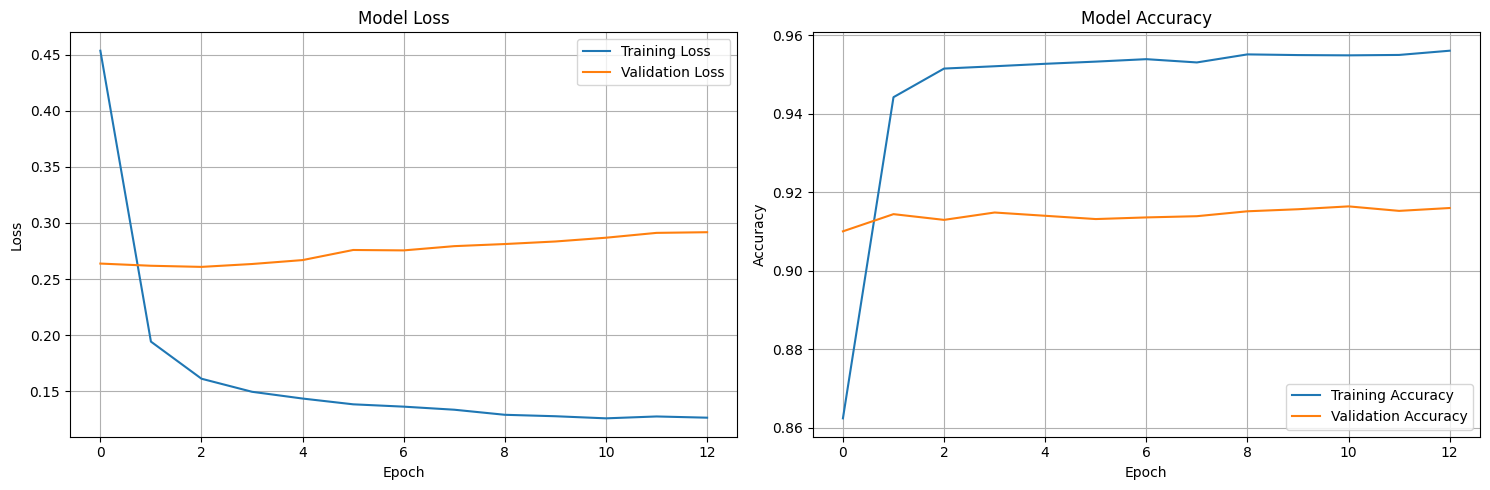

In [7]:
# Plot training history
baseline_model.plot_training_history(save_path='../results/visualizations/baseline_training_history.png')

## 4. Evaluate the Baseline Model

In [8]:
# Evaluate on test set
print("Evaluating baseline model on test set...")

# Basic evaluation metrics
test_metrics = baseline_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_metrics['test_loss']:.4f}")
print(f"Test Accuracy: {test_metrics['test_accuracy']:.4f}")

# Get predictions
print("\nGenerating predictions...")
y_pred = baseline_model.predict(X_test)
print(f"Predictions shape: {y_pred.shape}")

Evaluating baseline model on test set...
Test Loss: 0.2506
Test Accuracy: 0.9165

Generating predictions...
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
Predictions shape: (9592, 1)


In [9]:
# Comprehensive evaluation using our custom evaluator
print("Performing comprehensive evaluation...")

# Create evaluator
id_to_tag = {int(k): v for k, v in metadata['id_to_tag'].items()}
evaluator = NERModelEvaluator(id_to_tag)

# Evaluate the model
evaluation_results = evaluator.evaluate_model(y_test, y_pred, X_test)

print("\nEvaluation Results:")
print("=" * 50)

# Token-level metrics
token_metrics = evaluation_results['token_level']
print(f"Token-level Accuracy: {token_metrics['accuracy']:.4f}")
print(f"Token-level Precision: {token_metrics['precision']:.4f}")
print(f"Token-level Recall: {token_metrics['recall']:.4f}")
print(f"Token-level F1-Score: {token_metrics['f1_score']:.4f}")

# Sequence-level metrics
seq_metrics = evaluation_results['sequence_level']
print(f"\nSequence-level Accuracy: {seq_metrics['sequence_accuracy']:.4f}")
print(f"Exact Matches: {seq_metrics['exact_matches']}/{seq_metrics['total_sequences']}")

# Entity-level metrics
entity_metrics = evaluation_results['entity_level']
print(f"\nEntity-level Precision: {entity_metrics['precision']:.4f}")
print(f"Entity-level Recall: {entity_metrics['recall']:.4f}")
print(f"Entity-level F1-Score: {entity_metrics['f1_score']:.4f}")

Performing comprehensive evaluation...

Evaluation Results:
Token-level Accuracy: 0.9165
Token-level Precision: 0.9211
Token-level Recall: 0.9165
Token-level F1-Score: 0.9151

Sequence-level Accuracy: 0.9165
Exact Matches: 8791/9592

Entity-level Precision: 1.0000
Entity-level Recall: 0.7143
Entity-level F1-Score: 0.8333



Per-Tag Performance:
       precision  recall  f1_score  support
O         0.9727  0.9635    0.9681   6883.0
B-gpe     0.9717  0.8941    0.9313    614.0
B-tim     0.9651  0.7981    0.8737    104.0
B-geo     0.7342  0.8761    0.7989    662.0
B-per     0.6907  0.8837    0.7754    791.0
B-org     0.7726  0.4662    0.5815    532.0
B-art     0.0000  0.0000    0.0000      3.0
B-eve     0.0000  0.0000    0.0000      0.0
B-nat     0.0000  0.0000    0.0000      3.0


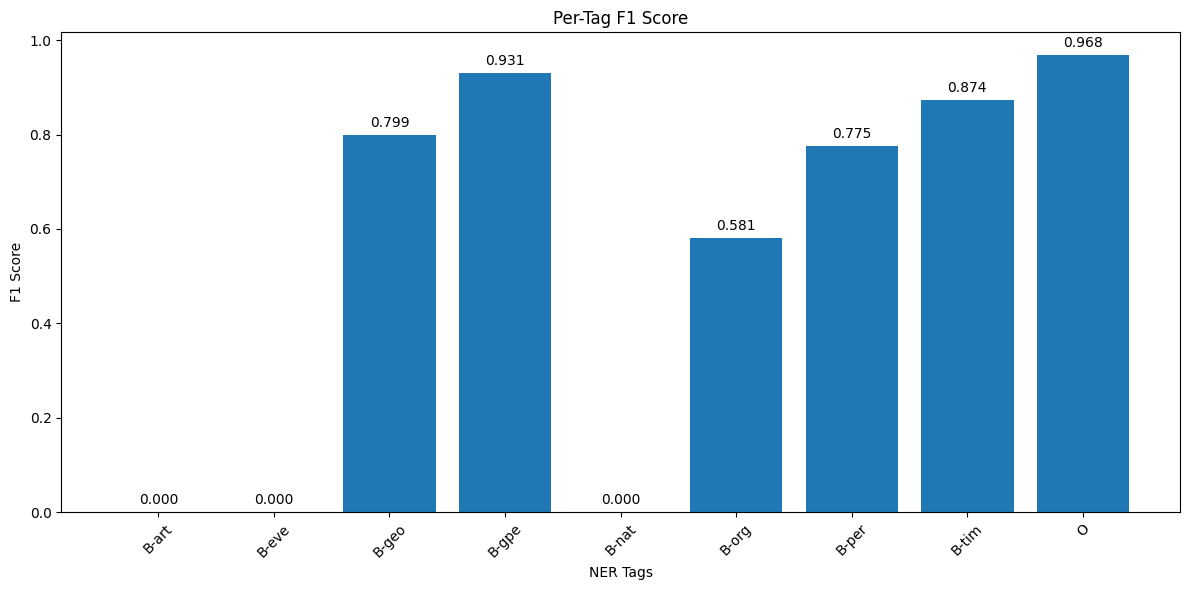

In [10]:
# Per-tag performance analysis
per_tag_metrics = evaluation_results['per_tag']
print("\nPer-Tag Performance:")
print("=" * 30)

# Convert to DataFrame for better display
per_tag_df = pd.DataFrame(per_tag_metrics).T
per_tag_df = per_tag_df.sort_values('f1_score', ascending=False)

print(per_tag_df.round(4))

# Plot per-tag F1 scores
evaluator.plot_per_tag_metrics(per_tag_metrics, metric='f1_score')

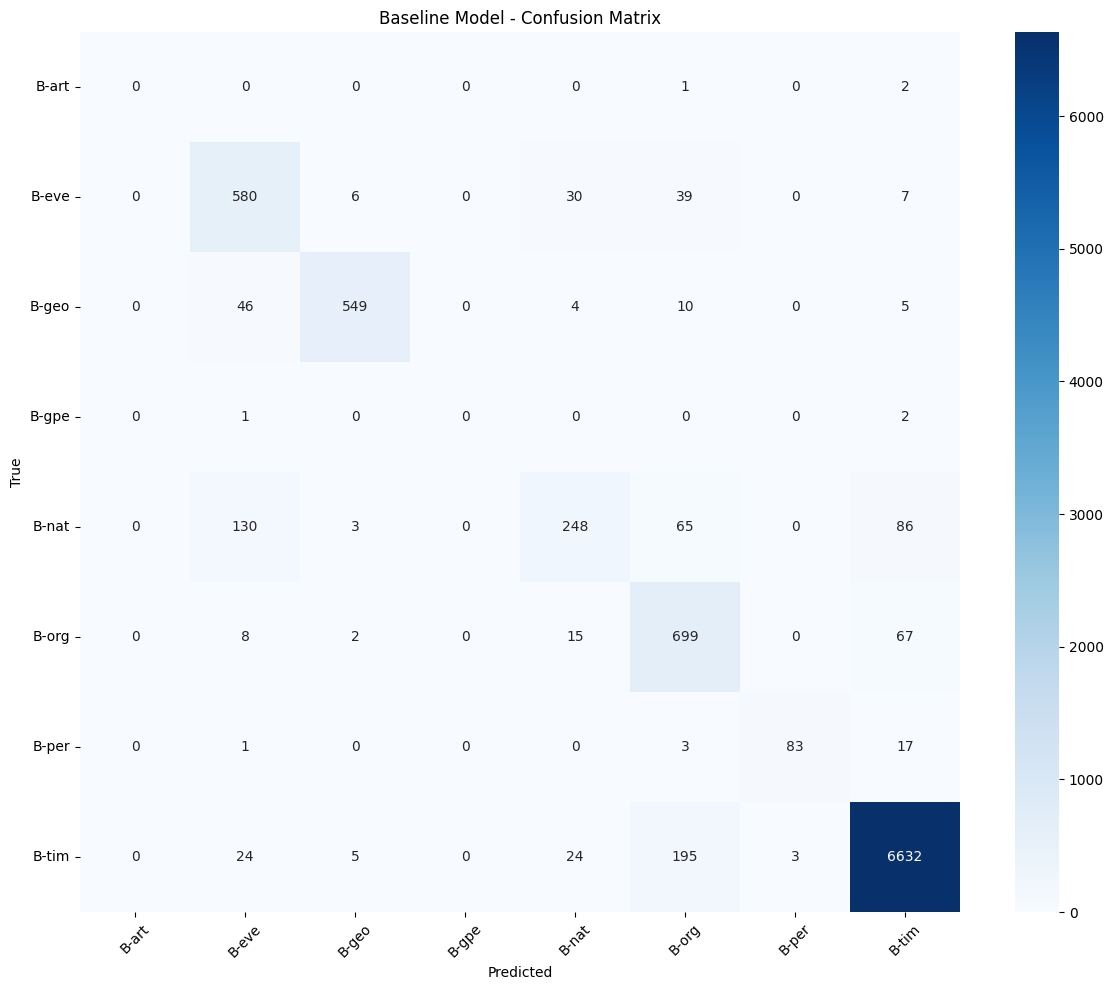

In [11]:
# Plot confusion matrix
confusion_matrix = evaluation_results['confusion_matrix']
evaluator.plot_confusion_matrix(confusion_matrix, title="Baseline Model - Confusion Matrix")

In [12]:
# Generate classification report
y_true_flat = evaluator._flatten_sequences(y_test)
y_pred_flat = evaluator._flatten_sequences(y_pred)

classification_report = evaluator.generate_classification_report(y_true_flat, y_pred_flat)
print("Detailed Classification Report:")
print("=" * 40)
print(classification_report)

Detailed Classification Report:
              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         3
       B-eve       0.00      0.00      0.00         0
       B-geo       0.73      0.88      0.80       662
       B-gpe       0.97      0.89      0.93       614
       B-nat       0.00      0.00      0.00         3
       B-org       0.77      0.47      0.58       532
       B-per       0.69      0.88      0.78       791
       B-tim       0.97      0.80      0.87       104
           O       0.97      0.96      0.97      6883

    accuracy                           0.92      9592
   macro avg       0.57      0.54      0.55      9592
weighted avg       0.92      0.92      0.92      9592



## 5. Error Analysis

In [13]:
# Analyze prediction errors
print("Error Analysis:")
print("=" * 20)

# Find sequences with lowest prediction accuracy
sequence_accuracies = []
for i in range(len(y_test)):
    true_seq = y_test[i]
    pred_seq = y_pred[i]
    
    # Calculate accuracy for this sequence (ignoring padding)
    non_pad_mask = true_seq != 0  # Assuming 0 is padding
    if non_pad_mask.sum() > 0:
        seq_acc = (true_seq[non_pad_mask] == pred_seq[non_pad_mask]).mean()
        sequence_accuracies.append((i, seq_acc))

# Sort by accuracy
sequence_accuracies.sort(key=lambda x: x[1])

print(f"\nWorst performing sequences (lowest accuracy):")
for i, (seq_idx, acc) in enumerate(sequence_accuracies[:5]):
    true_tags = [id_to_tag[tag_id] for tag_id in y_test[seq_idx] if tag_id != 0]
    pred_tags = [id_to_tag[tag_id] for tag_id in y_pred[seq_idx] if tag_id != 0]
    
    print(f"\nSequence {seq_idx} (Accuracy: {acc:.2f}):")
    print(f"True:  {' '.join(true_tags[:20])}{'...' if len(true_tags) > 20 else ''}")
    print(f"Pred:  {' '.join(pred_tags[:20])}{'...' if len(pred_tags) > 20 else ''}")

print(f"\nBest performing sequences (highest accuracy):")
for i, (seq_idx, acc) in enumerate(sequence_accuracies[-5:]):
    if acc < 1.0:  # Skip perfect predictions
        true_tags = [id_to_tag[tag_id] for tag_id in y_test[seq_idx] if tag_id != 0]
        pred_tags = [id_to_tag[tag_id] for tag_id in y_pred[seq_idx] if tag_id != 0]
        
        print(f"\nSequence {seq_idx} (Accuracy: {acc:.2f}):")
        print(f"True:  {' '.join(true_tags[:20])}{'...' if len(true_tags) > 20 else ''}")
        print(f"Pred:  {' '.join(pred_tags[:20])}{'...' if len(pred_tags) > 20 else ''}")
        break

Error Analysis:

Worst performing sequences (lowest accuracy):

Sequence 1 (Accuracy: 0.00):
True:  B-org
Pred:  B-per

Sequence 18 (Accuracy: 0.00):
True:  B-org
Pred:  B-geo

Sequence 19 (Accuracy: 0.00):
True:  B-per
Pred:  O

Sequence 22 (Accuracy: 0.00):
True:  B-org
Pred:  B-geo

Sequence 95 (Accuracy: 0.00):
True:  B-org
Pred:  O

Best performing sequences (highest accuracy):


In [14]:
# Analyze common prediction errors
error_counts = {}
total_errors = 0

for i in range(len(y_test)):
    true_seq = y_test[i]
    pred_seq = y_pred[i]
    
    # Find positions where predictions differ (ignoring padding)
    non_pad_mask = true_seq != 0
    error_mask = (true_seq != pred_seq) & non_pad_mask
    
    for j in range(len(true_seq)):
        if error_mask[j]:
            true_tag = id_to_tag[true_seq[j]]
            pred_tag = id_to_tag[pred_seq[j]]
            error_key = f"{true_tag} -> {pred_tag}"
            error_counts[error_key] = error_counts.get(error_key, 0) + 1
            total_errors += 1

# Display most common errors
print(f"\nMost Common Prediction Errors (Total: {total_errors:,}):")
sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
for i, (error, count) in enumerate(sorted_errors[:15]):
    percentage = (count / total_errors) * 100
    print(f"{i+1:2d}. {error}: {count:,} ({percentage:.1f}%)")


Most Common Prediction Errors (Total: 798):
 1. O -> B-per: 195 (24.4%)
 2. B-org -> B-geo: 130 (16.3%)
 3. B-org -> O: 86 (10.8%)
 4. B-per -> O: 67 (8.4%)
 5. B-org -> B-per: 65 (8.1%)
 6. B-gpe -> B-geo: 46 (5.8%)
 7. B-geo -> B-per: 39 (4.9%)
 8. B-geo -> B-org: 30 (3.8%)
 9. O -> B-geo: 24 (3.0%)
10. O -> B-org: 24 (3.0%)
11. B-tim -> O: 17 (2.1%)
12. B-per -> B-org: 15 (1.9%)
13. B-gpe -> B-per: 10 (1.3%)
14. B-per -> B-geo: 8 (1.0%)
15. B-geo -> O: 7 (0.9%)


## 6. Save Results

In [15]:
# Compile comprehensive results
baseline_results = {
    'model_info': {
        'model_type': 'baseline_feedforward',
        'architecture': 'feedforward_with_embeddings',
        'parameters': model_params,
        'training_params': training_params,
        'training_time_seconds': training_time,
        'total_parameters': baseline_model.model.count_params() if baseline_model.model else 0
    },
    'training_results': training_results,
    'test_metrics': test_metrics,
    'evaluation_results': {
        'token_level': evaluation_results['token_level'],
        'sequence_level': evaluation_results['sequence_level'],
        'entity_level': evaluation_results['entity_level']
    },
    'per_tag_metrics': evaluation_results['per_tag'],
    'error_analysis': {
        'total_errors': total_errors,
        'most_common_errors': dict(sorted_errors[:10])
    },
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'data_splits': {
            'train_size': len(X_train),
            'val_size': len(X_val),
            'test_size': len(X_test)
        }
    }
}

# Save results
results_path = '../results/baseline_results.json'
save_results(baseline_results, results_path)
print(f"Baseline model results saved to: {results_path}")

# Save predictions for later analysis
predictions_path = '../results/baseline_predictions.npz'
np.savez_compressed(
    predictions_path,
    y_true=y_test,
    y_pred=y_pred,
    X_test=X_test
)
print(f"Baseline predictions saved to: {predictions_path}")

Baseline model results saved to: ../results/baseline_results.json
Baseline predictions saved to: ../results/baseline_predictions.npz


## 7. Summary

In [16]:
print("Baseline Model Summary:")
print("=" * 30)
print(f"🏗️  Architecture: Feedforward Neural Network with Embeddings")
print(f"📊 Parameters: {baseline_model.model.count_params():,}")
print(f"⏱️  Training Time: {training_time/60:.1f} minutes")
print(f"📈 Epochs: {training_results['epochs_trained']}")

print(f"\n🎯 Performance Metrics:")
print(f"   • Token Accuracy: {token_metrics['accuracy']:.3f}")
print(f"   • Token F1-Score: {token_metrics['f1_score']:.3f}")
print(f"   • Sequence Accuracy: {seq_metrics['sequence_accuracy']:.3f}")
print(f"   • Entity F1-Score: {entity_metrics['f1_score']:.3f}")

print(f"\n🔍 Key Insights:")
best_tag = max(per_tag_metrics.keys(), key=lambda x: per_tag_metrics[x]['f1_score'])
worst_tag = min(per_tag_metrics.keys(), key=lambda x: per_tag_metrics[x]['f1_score'])
print(f"   • Best performing tag: {best_tag} (F1: {per_tag_metrics[best_tag]['f1_score']:.3f})")
print(f"   • Worst performing tag: {worst_tag} (F1: {per_tag_metrics[worst_tag]['f1_score']:.3f})")
print(f"   • Most common error: {sorted_errors[0][0]} ({sorted_errors[0][1]:,} occurrences)")

print(f"\n✅ Model and results saved successfully!")
print(f"📁 Files saved:")
print(f"   • Model: ../models/baseline_model.h5")
print(f"   • Results: ../results/baseline_results.json")
print(f"   • Predictions: ../results/baseline_predictions.npz")
print(f"   • Training plot: ../results/visualizations/baseline_training_history.png")

Baseline Model Summary:
🏗️  Architecture: Feedforward Neural Network with Embeddings
📊 Parameters: 401,669
⏱️  Training Time: 0.2 minutes
📈 Epochs: 13

🎯 Performance Metrics:
   • Token Accuracy: 0.916
   • Token F1-Score: 0.915
   • Sequence Accuracy: 0.916
   • Entity F1-Score: 0.833

🔍 Key Insights:
   • Best performing tag: O (F1: 0.968)
   • Worst performing tag: B-art (F1: 0.000)
   • Most common error: O -> B-per (195 occurrences)

✅ Model and results saved successfully!
📁 Files saved:
   • Model: ../models/baseline_model.h5
   • Results: ../results/baseline_results.json
   • Predictions: ../results/baseline_predictions.npz
   • Training plot: ../results/visualizations/baseline_training_history.png


## Conclusion

The baseline NER model has been successfully trained and evaluated:

**Model Characteristics:**
- Simple feedforward architecture with word embeddings
- No context awareness between words
- Limited understanding of sequence dependencies

**Expected Limitations:**
- Poor handling of unseen words
- Difficulty with entity boundaries
- No consideration of word order or context

**Next Steps:**
- Compare with advanced BiLSTM model
- Analyze areas for improvement
- Use insights to guide advanced model development